<h3>Load data</h3>

In [1]:
import json
import matplotlib.pyplot as plt
import string

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os

os.chdir(r'/content/drive/MyDrive/NLP2022')
!ls

cranfield		 main.py		  stopwordRemoval.py
evaluateAll.py		 output			  tokenization.py
evaluation.py		 __pycache__		  util.py
inflectionReduction.py	 README.txt
informationRetrieval.py  sentenceSegmentation.py


In [4]:
from inflectionReduction import InflectionReduction
from stopwordRemoval import StopwordRemoval
from informationRetrieval import InformationRetrieval

from sentenceSegmentation import SentenceSegmentation
from tokenization import Tokenization

from evaluateAll import Evaluation_metrics as em
from evaluation import Evaluation



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
# query_dict = json.load(open( "./cranfield/cran_queries.json", 'r'))[:]
# docs_dict = json.load(open("./cranfield/cran_docs.json", 'r'))[:]
# query_reduced = json.load(open('./output/stopword_removed_queries.txt', 'r'))
# docs_reduced = json.load(open('./output/stopword_removed_docs.txt', 'r'))
# qrels = json.load(open( "./cranfield/cran_qrels.json", 'r'))[:]
# docIDs= [item["id"] for item in docs_dict]

<h3>Load precprocessed docs and queries</h3>
These are obained from running the preprocessing modules or just run main.py

In [6]:
# Read queries
queries_json = json.load(open("./cranfield/cran_queries.json", 'r'))[:]
query_ids, queries = [item["query number"] for item in queries_json], [item["query"] for item in queries_json]

# Read documents(corpus)
docs_json = json.load(open("./cranfield/cran_docs.json", 'r'))[:]
doc_ids, docs = [item["id"] for item in docs_json], [item["body"] for item in docs_json]

# Loading preprocessed queries
preprocessed_queries = json.load(open('./output/stopword_removed_queries.txt', 'r'))

# Loading Preprocessed docs
preprocessed_docs = json.load(open('./output/stopword_removed_docs.txt', 'r'))

qrels = json.load(open("./cranfield/cran_qrels.json", 'r'))[:]

In [7]:
import math
import numpy as np
import pandas as pd
from math import log
from math import sqrt
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

def buildIndex(docs, docIDs, queries):
		"""
		Builds the document index in terms of the document
		IDs and stores it in the 'index' class variable
		Parameters
		----------
		arg1 : list
			A list of lists of lists where each sub-list is
			a document and each sub-sub-list is a sentence of the document
		arg2 : list
			A list of integers denoting IDs of the documents
		arg3 : 
			A list of lists of lists where each sub-list is a query and
			each sub-sub-list is a sentence of the query
		Returns
		-------
		None
		"""

		doc_dicts={} # dict of dicts :: docID: counter of words
		allWords=set()
		tf_idfs_doc={}
		idf={}

		for i,docID in enumerate(docIDs):
			ar=[]
			for sentence in docs[i]: 
				ar += sentence
			doc_dicts[docID]=Counter(ar)
			allWords |= set(ar)
		
		N=len(docs)
		for word in allWords:
			n=0
			for docID in docIDs:
				if word in doc_dicts[docID]: n+=1
			idf[word]= math.log(float((N+1)/(n+1)))

		
		for docID, doc_dict in doc_dicts.items():
			tf_idf={}
			if len(doc_dict)==0:
				tf_idfs_doc[docID]=tf_idf
				continue

			for word in doc_dict.keys():
				tf_idf[word] = doc_dict[word]*idf[word]

			tf_idfs_doc[docID]=tf_idf

		

		tf_idfs_qry={}
		for i,query in enumerate(queries):
			q_list=[]
			for sentence in query:
				q_list += sentence

			tf_idf=Counter(q_list)

			for word in tf_idf.keys():
				if word in idf: tf_idf[word] *= idf[word]
				else: tf_idf[word] = 0

			tf_idfs_qry[N+i+1]=tf_idf

		tfidf_combined=tf_idfs_doc.copy()
		tfidf_combined.update(tf_idfs_qry)
		tfidf_combined_df=pd.DataFrame.from_dict(tfidf_combined)
		tfidf_combined_df=tfidf_combined_df.fillna(0)
		tfidf_combined_df=tfidf_combined_df
		vec_rep=tfidf_combined_df.values
		vec_rep_docs = np.array(vec_rep[:,0:N])
		vec_rep_qry = np.array(vec_rep[:,N:])
		return vec_rep_docs, vec_rep_qry


In [8]:
# Evaluation metrics at k
def runEvaluation(qrels, doc_IDs_ordered, queries, k):

    evaluator = Evaluation()

    # Precision of each queries
    q_precision = []

    # Recall of each queries
    q_recall = []

    # Fscore of each queries
    q_fscore = []

    for i in range(len(doc_IDs_ordered)):
        true_doc_ids = [int(qrel["id"]) for qrel in qrels if int(qrel["query_num"]) == int(i+1)]
        precision = evaluator.queryPrecision(doc_IDs_ordered[i], i+1, true_doc_ids, k)
        q_precision.append(precision)
        recall = evaluator.queryRecall(doc_IDs_ordered[i], i+1, true_doc_ids, k)
        q_recall.append(recall)
        fscore = evaluator.queryFscore(doc_IDs_ordered[i], i+1, true_doc_ids, k)
        q_fscore.append(fscore)

    # ndcg for each query calculation
    q_ndcg = []
    for i in range(len(doc_IDs_ordered)):
        true_doc_ndcg_ids = [int(qrel["id"]) for qrel in qrels if int(qrel["query_num"]) == int(i+1)]
        true_doc_ndcg_position = [qrel["position"] for qrel in qrels if int(qrel["query_num"]) == int(i+1)]
        ndcg = evaluator.queryNDCG(doc_IDs_ordered[i], i+1, [true_doc_ndcg_ids, true_doc_ndcg_position], k)
        q_ndcg.append(ndcg)

    return q_precision, q_recall, q_fscore, q_ndcg

<h3>TF-IDF Representation</h3>

In [9]:
# Build document index and tf-idf
docs_vect, qry_vect = buildIndex(preprocessed_docs, doc_ids, preprocessed_queries)

<h1>0. Vector Space Model</h1>

<h3>Computing cosine similarity and ranking docs based on it</h3>

In [10]:
cosine_sim_vsm = np.matmul(docs_vect.T, qry_vect)
doc_IDs_ordered_vsm = (np.argsort(cosine_sim_vsm,axis=0)+1)[::-1].T.tolist()

<h3>Evaluation</h3>

Precision, Recall and F-score @ 1 : 0.5022222222222222, 0.08135190053229265, 0.13505608924260276
MAP, nDCG @ 1 : 0.5022222222222222, 0.5022222222222222
Precision, Recall and F-score @ 2 : 0.43777777777777777, 0.14135445316169837, 0.20120856185401442
MAP, nDCG @ 2 : 0.5733333333333334, 0.5789956449192463
Precision, Recall and F-score @ 3 : 0.3777777777777777, 0.17816118478682094, 0.22488757947638127
MAP, nDCG @ 3 : 0.5874074074074072, 0.6045831994907338
Precision, Recall and F-score @ 4 : 0.3377777777777778, 0.20815296897738816, 0.2383693286402648
MAP, nDCG @ 4 : 0.5930864197530864, 0.6188173005649743
Precision, Recall and F-score @ 5 : 0.3173333333333335, 0.24074132773965892, 0.2522073598955548
MAP, nDCG @ 5 : 0.5816913580246914, 0.609963911904853
Precision, Recall and F-score @ 6 : 0.29185185185185186, 0.2640825007278908, 0.2555210407149965
MAP, nDCG @ 6 : 0.5768432098765433, 0.6097746785004264
Precision, Recall and F-score @ 7 : 0.2800000000000001, 0.29340239869484747, 0.264479351290

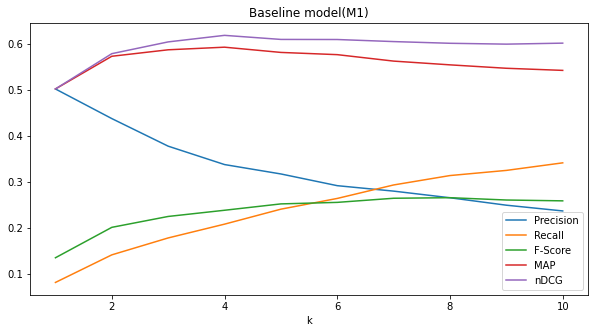

In [12]:
em(doc_IDs_ordered_vsm, query_ids, qrels, 0,"Baseline model(M1)", 0 ,"./output", 1)

<h2>1. LSA</h2>

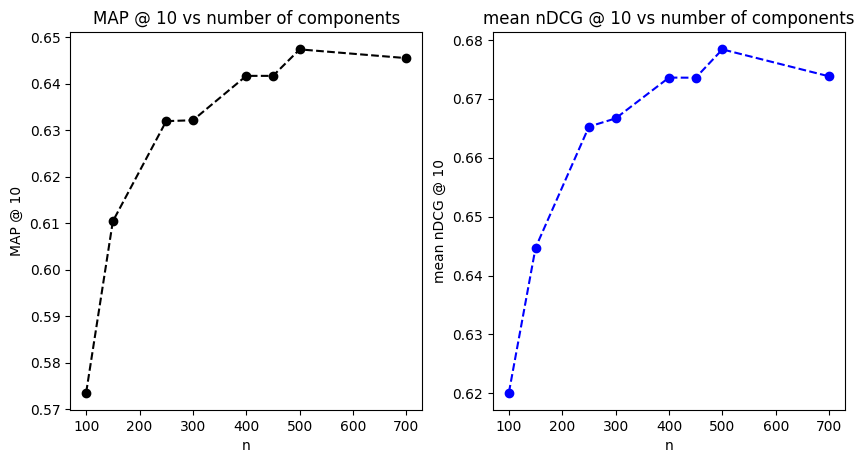

In [13]:
n_queries = 225
MAPs=[]
nDCGs=[]
k=10
comp_list = [100, 150, 250, 300, 400, 450, 500, 700]
evaluator=Evaluation()
query_IDs=np.arange(1,226)
all_docs_ID_retreived=[]
for n in comp_list:
  lsa = TruncatedSVD(n_components=n, random_state=1024)
  lsa.fit(docs_vect.T)
  docs_vect_transformed=lsa.transform(docs_vect.T).T
  qry_vect_transformed=lsa.transform(qry_vect.T).T
  docs_vect_transformed_norm=normalize(docs_vect_transformed, norm='l2', axis=0)
  qry_vect_transformed_norm=normalize(qry_vect_transformed, norm='l2', axis=0)
  cos_sim_matrix = np.matmul(qry_vect_transformed_norm.T, docs_vect_transformed_norm)
  docs_ID_retreived=[]
  for i in range(n_queries):
      docs_ID_retreived.append(1+np.argsort(cos_sim_matrix[i])[::-1])
  all_docs_ID_retreived.append(docs_ID_retreived)
  MAPs.append(evaluator.meanAveragePrecision(docs_ID_retreived, query_IDs, qrels, k))
  nDCGs.append(evaluator.meanNDCG(docs_ID_retreived, query_IDs, qrels, k))


fig,axes=plt.subplots(figsize=(10,5), ncols=2,dpi=100)
ax=axes[0]
ax.scatter(comp_list,MAPs,c='black')
ax.plot(comp_list,MAPs,c='black',linestyle='dashed')
ax.set_xlabel('n')
ax.set_ylabel("MAP @ "+str(k))
ax.set_title("MAP @ "+str(k)+" vs number of components")
ax=axes[1]
ax.scatter(comp_list,nDCGs,c='blue')
ax.plot(comp_list,nDCGs,c='blue',linestyle='dashed')
ax.set_xlabel('n')
ax.set_ylabel("mean nDCG @ "+str(k))
ax.set_title("mean nDCG @ "+str(k)+" vs number of components")
plt.show()

Best k rank approximation

In [14]:
print("max MAP@10 for n_components = ", comp_list[np.argmax(MAPs)])
print("max MAP@10 = ",round(MAPs[np.argmax(MAPs)],3))
print("nDCG@10 = ",round(nDCGs[np.argmax(MAPs)],3))

max MAP@10 for n_components =  500
max MAP@10 =  0.647
nDCG@10 =  0.678


Precision, Recall and F-score @ 1 : 0.6222222222222222, 0.10189456501148965, 0.16815823309500463
MAP, nDCG @ 1 : 0.6222222222222222, 0.6222222222222222
Precision, Recall and F-score @ 2 : 0.5533333333333333, 0.18238941728025393, 0.2576115259731806
MAP, nDCG @ 2 : 0.68, 0.6661366949633258
Precision, Recall and F-score @ 3 : 0.48444444444444457, 0.2313543807969416, 0.2917917920832457
MAP, nDCG @ 3 : 0.6948148148148149, 0.6846876099599445
Precision, Recall and F-score @ 4 : 0.4444444444444444, 0.2736237924932065, 0.31408157698940675
MAP, nDCG @ 4 : 0.6895061728395061, 0.6808138643372443
Precision, Recall and F-score @ 5 : 0.41244444444444484, 0.30875837577484866, 0.32668796367048275
MAP, nDCG @ 5 : 0.682938271604938, 0.6832758585115324
Precision, Recall and F-score @ 6 : 0.3785185185185186, 0.33366757854423795, 0.327369709694773
MAP, nDCG @ 6 : 0.6746283950617282, 0.6803946750452421
Precision, Recall and F-score @ 7 : 0.3549206349206353, 0.358425280186997, 0.3294013128875386
MAP, nDCG @ 7

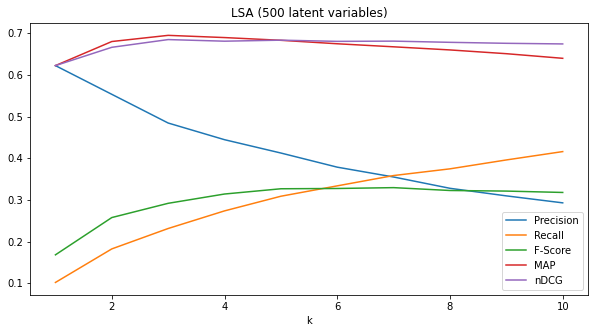

In [15]:
# Best k vlaue = 500 latent dimensions
n = 500
lsa = TruncatedSVD(n_components=n)
lsa.fit(docs_vect.T)
docs_vect_transformed=lsa.transform(docs_vect.T).T
qry_vect_transformed=lsa.transform(qry_vect.T).T
docs_vect_transformed_norm=normalize(docs_vect_transformed, norm='l2', axis=0)
qry_vect_transformed_norm=normalize(qry_vect_transformed, norm='l2', axis=0)
cosine_sim_lsa = np.matmul(docs_vect_transformed_norm.T, qry_vect_transformed_norm)
doc_IDs_ordered_lsa = (np.argsort(cosine_sim_lsa,axis=0)+1)[::-1].T.tolist()
em(doc_IDs_ordered_lsa, query_ids, qrels, n, "LSA (500 latent variables)", 0, "./output/", 1)

<h2>2. Vector space model with preprocessed docs and queries</h2>

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus.reader import wordnet
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
# Preprocessing steps
# Modify contracted words, remove punctuations and stopwords then finally perform lemmatization
import re
def modify_texts(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"i'll", "i will", text)
    text = re.sub(r"she'll", "she will", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"here's", "here is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"[^a-z]", " ", text) # Remove characters other than lower case letters
    text = re.sub(r"   ", " ", text) # Remove extra spaces
    return text

def punctuation_removal(text):
    """Remove=punctuations"""
    return re.sub("[.|,|;|?|!]", "", text)

STOPWORDS = set(stopwords.words('english'))
def stopwords_removal(text):
    """Remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def words_lemmatization(text):
    wordNetLemmatizer = WordNetLemmatizer()
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([wordNetLemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [18]:
# Preprocess every query and doc using the above methods

queryDf = pd.DataFrame(queries,columns = ['query'])
docsDf = pd.DataFrame(docs_json).drop(['author','bibliography','id','title'],axis=1)

docsDf['preprocessed'] = docsDf['body'].str.lower()
queryDf['preprocessed'] = queryDf['query'].str.lower()

docsDf['preprocessed'] = docsDf['preprocessed'].apply(modify_texts)
queryDf['preprocessed'] = queryDf['preprocessed'].apply(modify_texts)

docsDf['preprocessed'] = docsDf['preprocessed'].apply(lambda text: punctuation_removal(text))
queryDf['preprocessed'] = queryDf['preprocessed'].apply(lambda text: punctuation_removal(text))

docsDf['preprocessed'] = docsDf['preprocessed'].apply(lambda text: stopwords_removal(text))
queryDf['preprocessed'] = queryDf['preprocessed'].apply(lambda text: stopwords_removal(text))

docsDf['preprocessed'] = docsDf['preprocessed'].apply(lambda text: words_lemmatization(text))
queryDf['preprocessed'] = queryDf['preprocessed'].apply(lambda text: words_lemmatization(text))

docsDf.head()

,body,preprocessed
0,experimental investigation of the aerodynamics...,experimental investigation aerodynamics wing s...
1,simple shear flow past a flat plate in an inco...,simple shear flow past flat plate incompressib...
2,the boundary layer in simple shear flow past a...,boundary layer simple shear flow past flat pla...
3,approximate solutions of the incompressible la...,approximate solution incompressible laminar bo...
4,one-dimensional transient heat conduction into...,one dimensional transient heat conduction doub...


<h3>Prepare the corpus</h3>

In [19]:
corpus = docsDf['preprocessed'].tolist() + queryDf['preprocessed'].tolist()

<h3>Tf-idf representation</h3>

In [20]:
# we use sklearn tfidf vectorizer as it can directly take our corpus for performing transform and fitting operations
tfidfVectorizer = TfidfVectorizer()
X = tfidfVectorizer.fit_transform(corpus)
print("Vocabulary size: {}".format(X.shape[1]))

feature_names = tfidfVectorizer.get_feature_names()
columns = ['doc_' + str(i) for i in range(1,X.shape[0]+1)]

tfidfDf = pd.DataFrame(X.T.todense(), index=feature_names, columns=columns)
tfidfDf.head()

Vocabulary size: 5599


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,doc_1,doc_2,doc_3,doc_4,doc_5,doc_6,doc_7,doc_8,doc_9,doc_10,...,doc_1616,doc_1617,doc_1618,doc_1619,doc_1620,doc_1621,doc_1622,doc_1623,doc_1624,doc_1625
ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbreviated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ability,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# documents tfidf representation 
tf_idf_docs_vsm_preprocessed = tfidfDf[columns[:len(docsDf)]].values
# queries tfidf representation
vec_rep_queries_vsm_preprocessed = tfidfDf[columns[len(docsDf):]].values

In [22]:
cosine_sim_vsm_preprocessed = np.matmul(tf_idf_docs_vsm_preprocessed.T, vec_rep_queries_vsm_preprocessed)

# Documents are ordered based on cosine similarity
doc_IDs_ordered_vsm_preprocessed = (np.argsort(cosine_sim_vsm_preprocessed,axis=0)+1)[::-1].T.tolist()

Precision, Recall and F-score @ 1 : 0.6933333333333334, 0.11813159596691133, 0.19345722168811094
MAP, nDCG @ 1 : 0.6933333333333334, 0.6933333333333334
Precision, Recall and F-score @ 2 : 0.5666666666666667, 0.18859036312567867, 0.26577595814690075
MAP, nDCG @ 2 : 0.7333333333333333, 0.7107903582982895
Precision, Recall and F-score @ 3 : 0.5007407407407409, 0.24088233127783326, 0.3022374292347652
MAP, nDCG @ 3 : 0.733703703703704, 0.7066638961316302
Precision, Recall and F-score @ 4 : 0.46111111111111114, 0.28726653227454285, 0.32769150280712667
MAP, nDCG @ 4 : 0.72320987654321, 0.7021842146862074
Precision, Recall and F-score @ 5 : 0.41155555555555584, 0.3132692600374572, 0.3281620307874807
MAP, nDCG @ 5 : 0.7205185185185184, 0.708498755367499
Precision, Recall and F-score @ 6 : 0.37925925925925913, 0.3417134418666964, 0.3315977221122444
MAP, nDCG @ 6 : 0.7093382716049381, 0.7048744961377061
Precision, Recall and F-score @ 7 : 0.3561904761904765, 0.3688050070190457, 0.3340631005766173

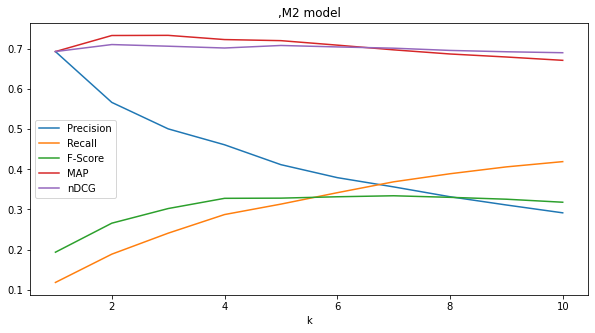

In [23]:
em(doc_IDs_ordered_vsm_preprocessed, query_ids, qrels,0,",M2 model", 0, "./output", 1)

<h1>2.1 LSA on preprocessed docs and queries</h1>



Precision, Recall and F-score @ 1 : 0.7111111111111111, 0.11932896649761521, 0.19555101678190603
MAP, nDCG @ 1 : 0.7111111111111111, 0.7111111111111111
Precision, Recall and F-score @ 2 : 0.58, 0.189421065383234, 0.2680826596409253
MAP, nDCG @ 2 : 0.74, 0.7125522784462277
Precision, Recall and F-score @ 3 : 0.5037037037037038, 0.2394821000763851, 0.3015240667707633
MAP, nDCG @ 3 : 0.7403703703703706, 0.7097030892045385
Precision, Recall and F-score @ 4 : 0.4666666666666667, 0.2907841124201932, 0.33201347120245844
MAP, nDCG @ 4 : 0.7311111111111113, 0.7110903670050986
Precision, Recall and F-score @ 5 : 0.4231111111111114, 0.32283845808704725, 0.33791370937300863
MAP, nDCG @ 5 : 0.7227345679012345, 0.7100374117622956
Precision, Recall and F-score @ 6 : 0.38962962962962977, 0.3526528499531631, 0.34136412062800353
MAP, nDCG @ 6 : 0.7118197530864196, 0.7058715122937398
Precision, Recall and F-score @ 7 : 0.36317460317460354, 0.3778328076135132, 0.3418012250840452
MAP, nDCG @ 7 : 0.70090211

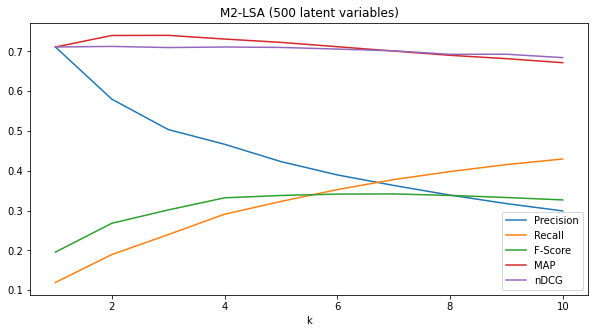

In [38]:
n = 500
lsa = TruncatedSVD(n_components=n)
lsa.fit(tf_idf_docs_vsm_preprocessed.T)
tf_idf_docs_vsm_preprocessed_transformed=lsa.transform(tf_idf_docs_vsm_preprocessed.T).T
vec_rep_queries_vsm_preprocessed_transformed=lsa.transform(vec_rep_queries_vsm_preprocessed.T).T
tf_idf_docs_vsm_preprocessed_transformed_norm=normalize(tf_idf_docs_vsm_preprocessed_transformed, norm='l2', axis=0)
vec_rep_queries_vsm_preprocessed_transformed_norm=normalize(vec_rep_queries_vsm_preprocessed_transformed, norm='l2', axis=0)
cosine_sim_lsa = np.matmul(tf_idf_docs_vsm_preprocessed_transformed_norm.T, vec_rep_queries_vsm_preprocessed_transformed_norm)
doc_IDs_ordered_preprocessed_lsa = (np.argsort(cosine_sim_lsa,axis=0)+1)[::-1].T.tolist()
em(doc_IDs_ordered_preprocessed_lsa, query_ids, qrels, n, "M2-LSA (500 latent variables)", 0, "./output/", 1)

<h1>II. Hypothesis testing</h1>

In [25]:
from scipy.special import stdtr

def hypothesis_test(q1, q2):

    """
    Two Sample t-test
    Inputs:
    q1 : List, sample 1 values
    q2 : List, sample 2 values
    Output:
    tf : float, t-value of hypothesis testing
    pf : float, p-value
    """
    a = np.array(q1)
    b = np.array(q2)
    a_bar = a.mean()
    a_var = a.var(ddof=1)
    a_dof = a.size - 1

    b_bar = b.mean()
    b_var = b.var(ddof=1)
    b_dof = b.size - 1

    tf = (a_bar - b_bar) / np.sqrt(a_var/a.size + b_var/b.size)
    dof = (a_var/a.size + b_var/b.size)**2 / (a_var**2/(a.size**2*a_dof) + b_var**2/(b.size**2*b_dof))
    pf = 2*stdtr(dof, -np.abs(tf))

    # print("formula: t = %g  p = %g" % (tf, pf))
    return tf, pf

<h3> Get evaluation metrics for all models for top "k" docs retreived<h3>

In [26]:
k = 10
#VSM
q_precision_vsm, q_recall_vsm, q_fscore_vsm, q_ndcg_vsm = runEvaluation(qrels, doc_IDs_ordered_vsm, queries, k)
# VSM with preprocessed queries and docs
q_precision_vsm_preprocessed, q_recall_vsm_preprocessed, q_fscore_vsm_preprocessed, q_ndcg_vsm_preprocessed = runEvaluation(qrels, doc_IDs_ordered_vsm_preprocessed, queries, k)
# LSA
q_precision_lsa, q_recall_lsa, q_fscore_lsa, q_ndcg_lsa = runEvaluation(qrels, doc_IDs_ordered_lsa, queries, k)
# LSA with preprocessed queries and docs
q_precision_lsa_preprocessed, q_recall_lsa_preprocessed, q_fscore_lsa_preprocessed, q_ndcg_lsa_preprocessed = runEvaluation(qrels, doc_IDs_ordered_preprocessed_lsa, queries, k)

<h2>1. VSM vs VSM_preprocessed</h2>

In [27]:
t,p = hypothesis_test(q_precision_vsm, q_precision_vsm_preprocessed)
print("Precision: t = %g  p = %g" % (t, p))
t,p = hypothesis_test(q_recall_vsm, q_recall_vsm_preprocessed)
print("Recall: t = %g  p = %g" % (t, p))
t,p = hypothesis_test(q_fscore_vsm, q_fscore_vsm_preprocessed)
print("Fscore: t = %g  p = %g" % (t, p))
t,p = hypothesis_test(q_ndcg_vsm, q_ndcg_vsm_preprocessed)
print("nDCG: t = %g  p = %g" % (t, p))

Precision: t = -3.16902  p = 0.0016347
Recall: t = -3.07628  p = 0.00222461
Fscore: t = -3.46671  p = 0.000577746
nDCG: t = -3.28127  p = 0.00111684


<h2>2. VSM vs LSA</h2>

In [28]:
t,p = hypothesis_test(q_precision_vsm, q_precision_lsa)
print("Precision: t = %g  p = %g" % (t, p))
t,p = hypothesis_test(q_recall_vsm, q_recall_lsa)
print("Recall: t = %g  p = %g" % (t, p))
t,p = hypothesis_test(q_fscore_vsm, q_fscore_lsa)
print("Fscore: t = %g  p = %g" % (t, p))
t,p = hypothesis_test(q_ndcg_vsm, q_ndcg_lsa)
print("nDCG: t = %g  p = %g" % (t, p))

Precision: t = -3.17567  p = 0.00159919
Recall: t = -2.9365  p = 0.00349079
Fscore: t = -3.38497  p = 0.000774818
nDCG: t = -2.63744  p = 0.00864995


<h2>3. LSA vs VSM_preprocessed</h2>


In [29]:
t,p = hypothesis_test(q_precision_lsa, q_precision_vsm_preprocessed)
print("Precision: t = %g  p = %g" % (t, p))
t,p = hypothesis_test(q_recall_lsa, q_recall_vsm_preprocessed)
print("Recall: t = %g  p = %g" % (t, p))
t,p = hypothesis_test(q_fscore_lsa, q_fscore_vsm_preprocessed)
print("Fscore: t = %g  p = %g" % (t, p))
t,p = hypothesis_test(q_ndcg_lsa, q_ndcg_vsm_preprocessed)
print("nDCG: t = %g  p = %g" % (t, p))

Precision: t = 0.0735069  p = 0.941436
Recall: t = -0.124429  p = 0.901032
Fscore: t = -0.00771477  p = 0.993848
nDCG: t = -0.649749  p = 0.516188


<h2>4. LSA_preprocessed vs VSM_preprocessed</h2>


In [30]:
t,p = hypothesis_test(q_precision_lsa_preprocessed, q_precision_vsm_preprocessed)
print("Precision: t = %g  p = %g" % (t, p))
t,p = hypothesis_test(q_recall_lsa_preprocessed, q_recall_vsm_preprocessed)
print("Recall: t = %g  p = %g" % (t, p))
t,p = hypothesis_test(q_fscore_lsa_preprocessed, q_fscore_vsm_preprocessed)
print("Fscore: t = %g  p = %g" % (t, p))
t,p = hypothesis_test(q_ndcg_lsa_preprocessed, q_ndcg_vsm_preprocessed)
print("nDCG: t = %g  p = %g" % (t, p))

Precision: t = 0.493611  p = 0.621823
Recall: t = 0.453204  p = 0.650621
Fscore: t = 0.575398  p = 0.565312
nDCG: t = -0.208915  p = 0.83461


<h2>5. LSA vs LSA_preprocessed</h2>


In [31]:
t,p = hypothesis_test(q_precision_lsa, q_precision_lsa_preprocessed)
print("Precision: t = %g  p = %g" % (t, p))
t,p = hypothesis_test(q_recall_lsa, q_recall_lsa_preprocessed)
print("Recall: t = %g  p = %g" % (t, p))
t,p = hypothesis_test(q_fscore_lsa, q_fscore_lsa_preprocessed)
print("Fscore: t = %g  p = %g" % (t, p))
t,p = hypothesis_test(q_ndcg_lsa, q_ndcg_lsa_preprocessed)
print("nDCG: t = %g  p = %g" % (t, p))

Precision: t = -0.411169  p = 0.681145
Recall: t = -0.574549  p = 0.565885
Fscore: t = -0.571451  p = 0.56798
nDCG: t = -0.447299  p = 0.654876


<h1> 3. CLUSTERING <h1>

n_clusters = 2, silhouette score = 0.010257327017479027)
n_clusters = 3, silhouette score = 0.013799726781534802)
n_clusters = 4, silhouette score = 0.014305693447753082)
n_clusters = 5, silhouette score = 0.016136900610171083)
n_clusters = 6, silhouette score = 0.017899351009227835)
n_clusters = 7, silhouette score = 0.014806481644540535)
n_clusters = 8, silhouette score = 0.017095438152771886)
n_clusters = 9, silhouette score = 0.01861060239768222)
n_clusters = 10, silhouette score = 0.01943283002667419)


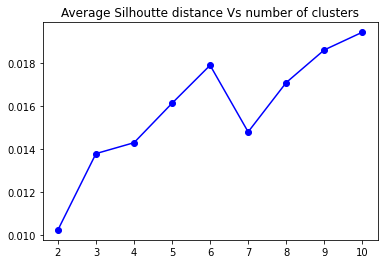

In [32]:


from sys import version_info
import json
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans

# For hypothesis testing
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr



import warnings
warnings.filterwarnings("ignore") 
 
# tf-idf representation of documents

docs_vect_km= tfidfDf[columns[:len(docsDf)]].values
qry_vect_km= tfidfDf[columns[len(docsDf):]].values

clusterDf = docs_vect_km.T
ss_metric = []
# Getting optimal number of clusters from 2 to 11
k_list = np.arange(2, 11)
for k in k_list:
    # Applying K-means clustering algorithm
    kMClusterer = KMeans(n_clusters=k)
    prediction = kMClusterer.fit_predict(clusterDf)
    # Cluster centers
    centers = kMClusterer.cluster_centers_
    s_score = silhouette_score(clusterDf, prediction)
    ss_metric.append(s_score)
    print("n_clusters = {}, silhouette score = {})".format(k, s_score))
    
plt.plot(list(range(2,11)),ss_metric, marker='o',color= 'b')
plt.title("Average Silhoutte distance Vs number of clusters")
plt.show()

Optimal number of clusters

In [33]:
k_best = 6

In [34]:
kMClusterer = KMeans(n_clusters=k_best, random_state=5)
# KMC fitting
kMClusterer.fit(docs_vect_km.T)
kMClusterer.cluster_centers_.shape

(6, 5599)

<h3>Grouping docs to their clusters</h3>

In [35]:
docs_clusters_dict = {}
for i in range(1400):
    try :
        docs_clusters_dict[kMClusterer.labels_[i]] += [i]
    except :
        docs_clusters_dict[kMClusterer.labels_[i]] = [i]

without clustering, Average Retrieval time : 0.012363311979505751
clustering method, Retrieval time : 0.006034579806857639


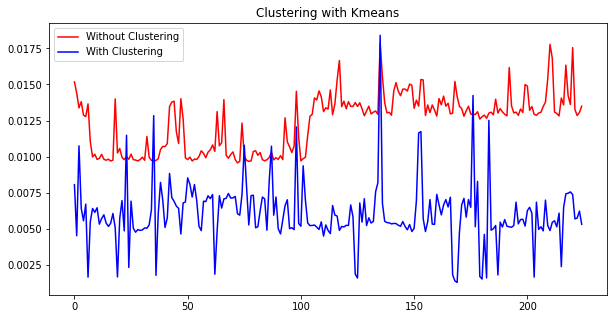

In [36]:
# Without Clustering
start_one = time.time()
# Iterate over all queries and store average retrieval time
without_clustering = []
for j in range(225):
    start_two = time.time()
    cosine_sim_without_clustering = []
    for i in range(1400):
        cosine_sim_without_clustering.append(np.matmul(docs_vect_km[:,i].T, qry_vect_km[:,j]))
    cosine_sim_without_clustering = np.array(cosine_sim_without_clustering)
    doc_IDs_ordered_without_clustering = (np.argsort(cosine_sim_without_clustering,axis=0)+1)[::-1].T.tolist()
    end_two = time.time()
    without_clustering.append(end_two - start_two)
end_one = time.time()
print("without clustering, Average Retrieval time : "+str((end_one-start_one)/225))

# With CLustering
start_one = time.time()
with_clustering = []
doc_IDs_ordered_kmeans = []
for j in range(225):
    start_two = time.time()
    cluster = np.argmax(np.matmul(qry_vect_km[:,j].T, kMClusterer.cluster_centers_.T))
    cluster_docs = docs_vect_km[:, docs_clusters_dict[cluster]]
    cosine_sim_with_clustering = np.matmul(cluster_docs.T,qry_vect_km[:,0])
    doc_IDs_ordered_with_clustering = (np.argsort(cosine_sim_with_clustering,axis=0))[::-1].T.tolist()
    doc_IDs_ordered_kmeans.append(doc_IDs_ordered_with_clustering)
    end_two = time.time()
    with_clustering.append(end_two - start_two)
end_one = time.time()
print("clustering method, Retrieval time : "+str((end_one-start_one)/225))


# Plotting
plt.figure(figsize = (10,5))
plt.title('Clustering with Kmeans')
plt.plot(range(225), without_clustering, label = 'Without Clustering', color='r')
plt.plot(range(225), with_clustering, label = 'With Clustering', color='b')
plt.legend()
plt.show()

<h2> Hypothesis Testing </h2>

In [37]:
t,p = hypothesis_test(without_clustering, with_clustering)
print("t = %g  p = %g" % (t, p))

t = 32.9048  p = 2.78211e-121
